In [56]:
import pandas as pd

In [57]:
csv_path = "ETTm1.csv"
data_frame = pd.read_csv(csv_path)
data_frame.head(5)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [58]:
# 防止时间非递增
data_frame.sort_values(by=["date"], inplace=True, ascending=True)
data_frame = data_frame.drop(columns=["date"])
data_frame.head(5)

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


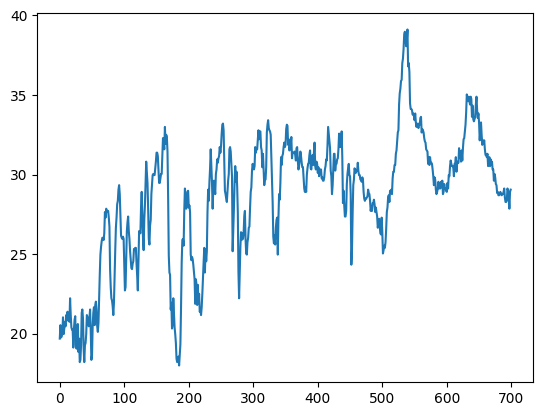

In [ ]:
##
## TEST

##

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

X = torch.tensor((data_frame["OT"][:1024].to_numpy())).float()

plt.plot(X[100:800])

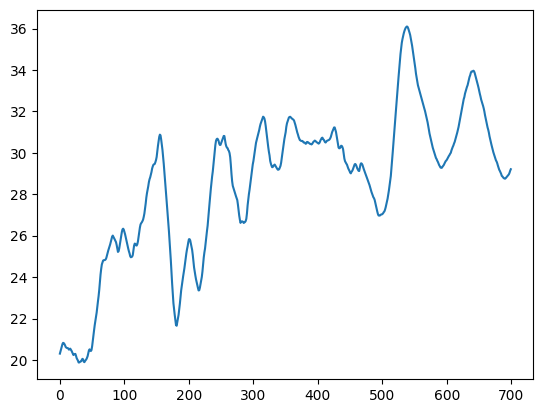

In [60]:
def moving_average(x, window_size):
    # 使用一维卷积来计算移动平均
    kernel = torch.ones(window_size) / window_size
    kernel = kernel.view(
        1, 1, -1
    )  # 调整卷积核的形状 [out_channels, in_channels, kernel_size]

    # 将数据扩展到[1, 1, N]形状以便卷积操作
    x = x.view(1, 1, -1)

    # 使用卷积进行移动平均（相当于趋势）
    trend = F.conv1d(x, kernel, padding=window_size // 2)
    trend = trend.view(-1)  # 转换回形状[N]

    # 计算季节性/残差部分
    seasonality = x.view(-1) - trend

    return trend, seasonality


X_t, X_s = moving_average(X, 25)
plt.plot(X_t[100:800])

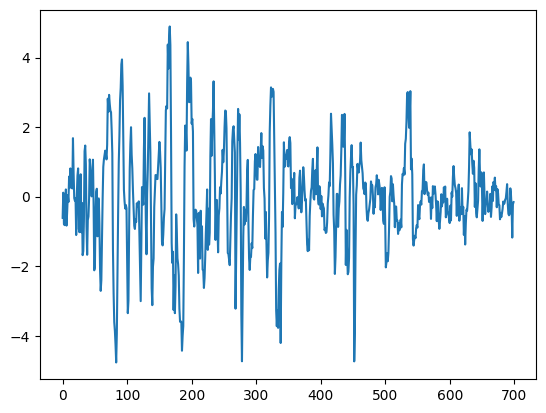

In [61]:
plt.plot(X_s[100:800])

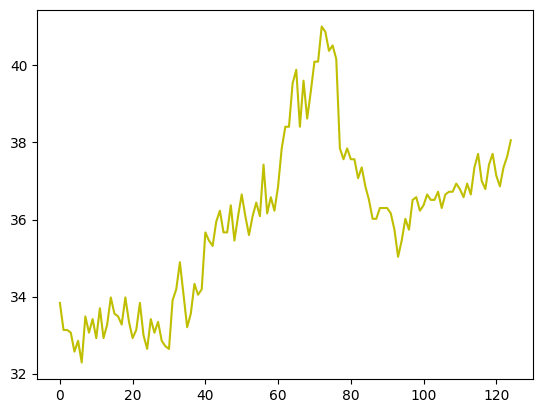

In [62]:
Y=torch.tensor((data_frame["OT"][1024:1200].to_numpy())).float()
plt.plot(Y[25:150],color='y')

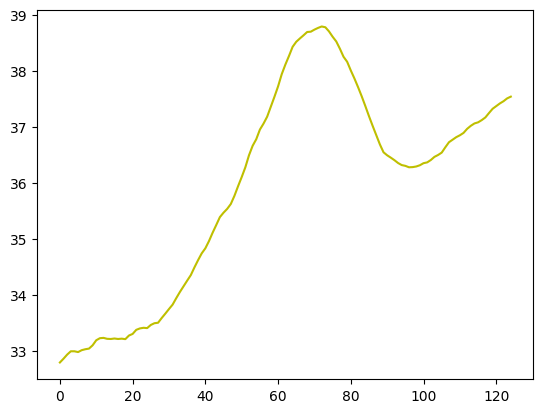

In [65]:
Y_t, Y_s = moving_average(Y, 25)
plt.plot(Y_t[25:150], color="y")

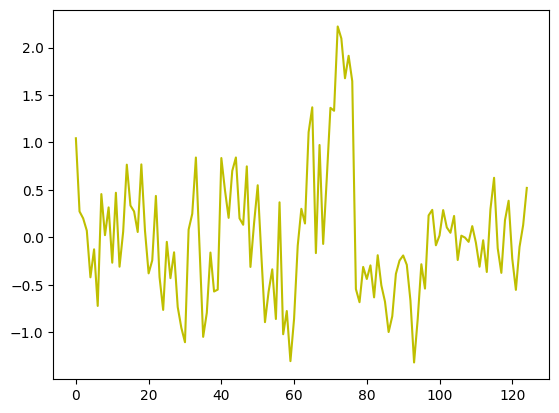

In [64]:
plt.plot(Y_s[25:150], color="y")

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

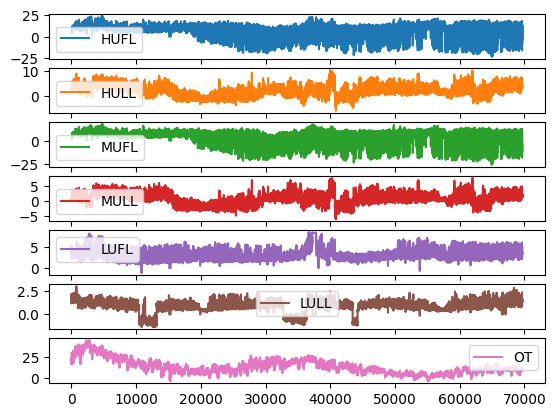

In [16]:
data_frame.plot(subplots=True)

In [17]:
import torch

torch.set_default_dtype(torch.double)


In [18]:
# GPU
use_cuda = True
print(f"{torch.cuda.is_available()=}")
print(f"{use_cuda=}")
device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu")
print(f"{device=}")

torch.cuda.is_available()=True
use_cuda=True
device=device(type='cuda', index=0)


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = torch.tensor(data_frame.to_numpy())
scaler.fit(data)
data = scaler.transform(data)
# data in [T,C]
data.shape

(69680, 7)

$$

X_S(i)=D[i:i+P]\in R^{P\times C} \\

Y_S(i)=D[i+P:i+P+F]\in R^{F\times C} \\

L=L(D)-P-F+1

$$

In [20]:
from torch.utils.data import DataLoader, Dataset


class MyDataset(Dataset):

    def __init__(self, D, P, F) -> None:
        super().__init__()
        self.D = D
        self.F = F
        self.P = P

    def __getitem__(self, i: int) -> torch.Tensor:
        X_s_i = self.D[i : i + self.P]
        Y_s_i = self.D[i + self.P : i + self.P + self.F]
        return X_s_i, Y_s_i

    def __len__(self):
        return len(self.D) - self.P - self.F + 1

In [21]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn


class Model(nn.Module):

    def __init__(self, P: int, F: int, C: int) -> None:
        super().__init__()
        self.P = P
        self.F = F
        self.C = C
        self.l = nn.Linear(P, F)

    def forward(self, X_batch: torch.Tensor) -> torch.Tensor:
        X_batch = X_batch.permute(0, 2, 1)  # [B,P,C]->[B,C,P]
        Y_pred: torch.Tensor = self.l(X_batch)  # [B,C,P]@[P,F]=[B,C,F]
        Y_pred = Y_pred.permute(0, 2, 1)  # [B,C,F]->[B,F,C]
        return Y_pred

In [22]:
P = 96
F = 96
C = data.shape[1]
B = 16

model = Model(P=P, F=F, C=C).to(device=device)
crit = nn.MSELoss()
opt = optim.Adam(model.parameters())

mse_loss_list = []
mae_loss_list = []
for epoch in tqdm(range(20)):
    mse_loss: torch.Tensor = None
    for X_batch, Y_batch in DataLoader(MyDataset(D=data, P=P, F=F), batch_size=B):
        X_batch: torch.Tensor = X_batch.to(device=device)
        Y_batch: torch.Tensor = Y_batch.to(device=device)
        opt.zero_grad()
        Y_pred: torch.Tensor = model(X_batch)
        mse_loss: torch.Tensor = crit(Y_batch, Y_pred)
        mae_loss: torch.Tensor = torch.mean(torch.abs(Y_batch - Y_pred))
        mse_loss.backward()
        opt.step()
    mse_loss_list.append(mse_loss.item())
    mae_loss_list.append(mae_loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

(0.136349092180042, 0.2744224561142782)

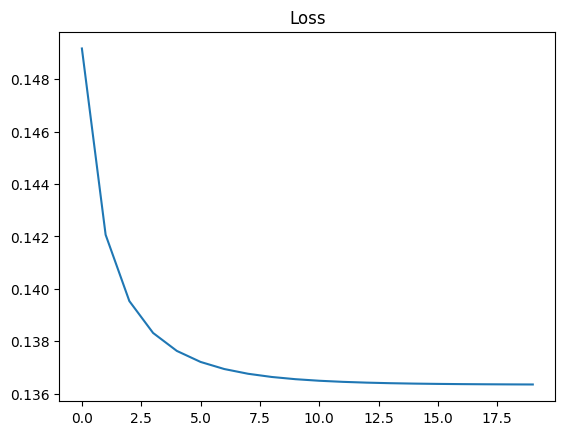

In [24]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(mse_loss_list)
mse_loss_list[-1], mae_loss_list[-1]

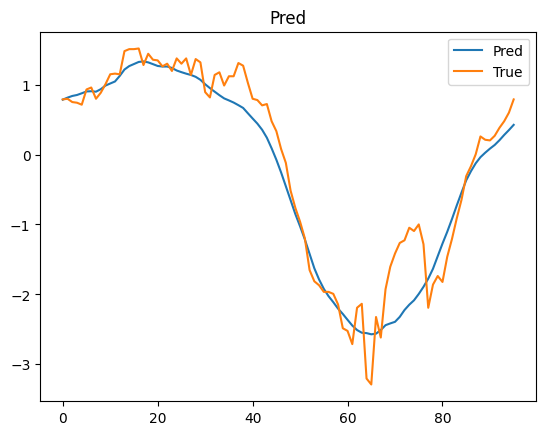

In [12]:
plt.title("Pred")
plt.plot(Y_pred[0, :, 0].cpu().detach(),label="Pred")
plt.plot(Y_batch[0, :, 0].cpu(),label="True")
plt.legend()